# Cricket Pipeline Bronze Layer Quality Checks

This notebook contains quality checks for the bronze layer data in the Cricket Pipeline project. We'll explore the data quality and run various checks to ensure the data is ready for further processing.

## 1. Setup Environment

First, let's set up our environment and import the necessary libraries. We'll use the existing project structure and virtual environment.

In [14]:
# Import required libraries
from pathlib import Path
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to Python path to allow module imports
# Fix the path calculation to correctly find the project root
current_dir = os.path.abspath('')
# Print current directory to debug
print(f"Current directory: {current_dir}")

# The correct way to get to the project root from the notebook
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
print(f"Project root: {project_root}")

# Add the project root to the Python path
sys.path.append(project_root)

# Make sure the path contains our project root
print(f"Python path: {sys.path}")

# Import project-specific modules
from etl.common import get_spark, load_yml, project_root

# Set plot styling
plt.style.use('ggplot')
sns.set(style="whitegrid")

Current directory: c:\Projects\CricketPipeline\notebooks\explorations
Project root: c:\Projects\CricketPipeline
Python path: ['C:\\Users\\wasav\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'C:\\Users\\wasav\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'C:\\Users\\wasav\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'C:\\Users\\wasav\\AppData\\Local\\Programs\\Python\\Python39', 'c:\\Projects\\CricketPipeline\\.venv', '', 'c:\\Projects\\CricketPipeline\\.venv\\lib\\site-packages', 'c:\\Projects\\CricketPipeline\\.venv\\lib\\site-packages\\win32', 'c:\\Projects\\CricketPipeline\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Projects\\CricketPipeline\\.venv\\lib\\site-packages\\Pythonwin', 'c:\\Projects', 'c:\\Projects', 'c:\\Projects', 'c:\\Projects', 'c:\\Projects', 'c:\\Projects', 'c:\\Projects\\CricketPipeline']


## 2. Load Configuration and Initialize Spark

Now, let's load the configuration from the YAML files and initialize a Spark session with the appropriate settings.

In [15]:
# Load configuration
root = project_root()
cfg = load_yml(str(root / "configs" / "bronze_config.yml"))
storage_format = cfg["storage"].get("format", "parquet")
base_path = cfg["storage"]["base_path"]

# Initialize Spark
spark = get_spark("bronze-quality-checks")

# Print configuration details
print(f"Project Root: {root}")
print(f"Storage Format: {storage_format}")
print(f"Base Path: {base_path}")
print(f"Available Tables: {list(cfg['tables'].keys())}")

# Print Spark UI URL
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

Project Root: C:\Projects\CricketPipeline
Storage Format: parquet
Base Path: data/processed/bronze
Available Tables: ['matches', 'deliveries', 'innings']
Spark UI: http://host.docker.internal:4040


## 3. Define Quality Check Functions

Let's define some functions to check the quality of our bronze layer data. These functions will help us identify issues like missing values, duplicates, and schema inconsistencies.

In [16]:
def check_null_values(df, threshold=0.05):
    """
    Check for null values in each column of the DataFrame.
    
    Args:
        df: Spark DataFrame to check
        threshold: Maximum acceptable percentage of nulls (default: 5%)
        
    Returns:
        Pandas DataFrame with null statistics
    """
    total_count = df.count()
    if total_count == 0:
        return pd.DataFrame({"column": ["No data"], "null_count": [0], "null_percent": [0], "status": ["FAIL"]})
    
    null_counts = []
    
    for col in df.columns:
        null_count = df.filter(df[col].isNull()).count()
        null_percent = null_count / total_count if total_count > 0 else 0
        status = "PASS" if null_percent <= threshold else "FAIL"
        
        null_counts.append({
            "column": col,
            "null_count": null_count,
            "null_percent": null_percent * 100,  # Convert to percentage
            "status": status
        })
    
    return pd.DataFrame(null_counts)

def check_duplicates(df, key_columns):
    """
    Check for duplicate records based on key columns.
    
    Args:
        df: Spark DataFrame to check
        key_columns: List of columns that should uniquely identify each record
        
    Returns:
        Dictionary with duplicate statistics
    """
    total_count = df.count()
    distinct_count = df.select(key_columns).distinct().count()
    duplicate_count = total_count - distinct_count
    duplicate_pct = (duplicate_count / total_count) * 100 if total_count > 0 else 0
    
    result = {
        "total_records": total_count,
        "unique_records": distinct_count,
        "duplicate_records": duplicate_count,
        "duplicate_percent": duplicate_pct,
        "status": "PASS" if duplicate_count == 0 else "FAIL"
    }
    
    # If there are duplicates, show some examples
    if duplicate_count > 0:
        # Count occurrences of each key combination
        dup_df = df.groupBy(key_columns).count().filter("count > 1").orderBy("count", ascending=False)
        result["examples"] = dup_df.limit(5).toPandas() if dup_df.count() > 0 else None
    
    return result

def check_schema_consistency(df, expected_schema):
    """
    Check if the DataFrame schema matches the expected schema.
    
    Args:
        df: Spark DataFrame to check
        expected_schema: Dictionary of column names and expected data types
        
    Returns:
        Pandas DataFrame with schema comparison results
    """
    schema_results = []
    
    for col_name, expected_type in expected_schema.items():
        if col_name in df.columns:
            actual_type = df.schema[col_name].dataType.simpleString()
            status = "PASS" if expected_type == actual_type else "FAIL"
            
            schema_results.append({
                "column": col_name,
                "expected_type": expected_type,
                "actual_type": actual_type,
                "status": status
            })
        else:
            schema_results.append({
                "column": col_name,
                "expected_type": expected_type,
                "actual_type": "MISSING",
                "status": "FAIL"
            })
    
    return pd.DataFrame(schema_results)

def check_value_distributions(df, column, expected_values=None):
    """
    Check the distribution of values in a column.
    
    Args:
        df: Spark DataFrame to check
        column: Column to check value distribution
        expected_values: Optional list of expected values
        
    Returns:
        Dictionary with value distribution statistics
    """
    # Get value counts
    value_counts = df.groupBy(column).count().orderBy("count", ascending=False)
    
    # Convert to pandas for easier analysis
    pd_value_counts = value_counts.toPandas()
    
    # Check if there are unexpected values
    unexpected_values = []
    if expected_values is not None:
        unexpected_values = [val for val in pd_value_counts[column].tolist() 
                            if val not in expected_values and val is not None]
    
    result = {
        "column": column,
        "value_counts": pd_value_counts,
        "total_distinct_values": value_counts.count(),
        "has_unexpected_values": len(unexpected_values) > 0 if expected_values else False,
        "unexpected_values": unexpected_values if expected_values else None
    }
    
    return result

## 4. Perform Basic Checks on Bronze Tables

Now that we have our quality check functions, let's load the bronze data and run the checks on the tables specified in the configuration.

In [17]:
# Get list of bronze tables from config
tables = cfg["tables"]

# Function to load a bronze table
def load_bronze_table(table_name):
    if table_name not in tables:
        print(f"Table {table_name} not found in configuration")
        return None
    
    table_path = root / tables[table_name]["target_path"]
    if not table_path.exists():
        print(f"Path {table_path} does not exist")
        return None
    
    print(f"Loading table from {table_path}")
    try:
        df = spark.read.format(storage_format).load(str(table_path))
        print(f"Loaded {df.count()} rows and {len(df.columns)} columns")
        return df
    except Exception as e:
        print(f"Error loading table: {str(e)}")
        return None

# Check if each table exists and perform quality checks
for table_name in tables.keys():
    print(f"\n{'='*50}")
    print(f"Checking table: {table_name}")
    print(f"{'='*50}")
    
    df = load_bronze_table(table_name)
    
    if df is not None:
        # Display schema
        print("\nTable Schema:")
        df.printSchema()
        
        # Check for nulls
        print("\nNull Value Check:")
        null_check = check_null_values(df)
        display(null_check)
        
        # Check for duplicates (using all columns as a simple example)
        # In practice, you would specify key columns based on your data model
        print("\nDuplicate Check:")
        key_columns = ["src_file_path"]  # Add more appropriate key columns
        if table_name == "matches" and "match_id" in df.columns:
            key_columns = ["match_id"]
        elif table_name == "deliveries" and all(col in df.columns for col in ["match_id", "inning_no", "over_no", "ball_in_over"]):
            key_columns = ["match_id", "inning_no", "over_no", "ball_in_over"]
        
        dup_check = check_duplicates(df, key_columns)
        for key, value in dup_check.items():
            if key != "examples":
                print(f"{key}: {value}")
        
        if "examples" in dup_check and dup_check["examples"] is not None:
            print("\nDuplicate Examples:")
            display(dup_check["examples"])
    else:
        print(f"Skipping checks for {table_name} as table could not be loaded")


Checking table: matches
Loading table from C:\Projects\CricketPipeline\data\processed\bronze\matches
Loaded 1169 rows and 21 columns

Table Schema:
root
 |-- match_id: string (nullable = true)
 |-- match_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- city: string (nullable = true)
 |-- match_start_date: string (nullable = true)
 |-- match_end_date: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- result: string (nullable = true)
 |-- result_margin: integer (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- officials: struct (nullable = true)
 |    |-- match_referees: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- reserve_umpires: array (nullable = true)
 |    |    |-- element: string (c

,column,null_count,null_percent,status
0,match_id,0,0.000000,PASS
1,match_type,0,0.000000,PASS
2,gender,0,0.000000,PASS
3,venue,0,0.000000,PASS
4,city,51,4.362703,PASS
5,match_start_date,0,0.000000,PASS
6,match_end_date,1167,99.828914,FAIL
7,team1,0,0.000000,PASS
8,team2,0,0.000000,PASS
9,toss_winner,0,0.000000,PASS



Duplicate Check:
total_records: 1169
unique_records: 1169
duplicate_records: 0
duplicate_percent: 0.0
status: PASS

Checking table: deliveries
Loading table from C:\Projects\CricketPipeline\data\processed\bronze\deliveries
total_records: 1169
unique_records: 1169
duplicate_records: 0
duplicate_percent: 0.0
status: PASS

Checking table: deliveries
Loading table from C:\Projects\CricketPipeline\data\processed\bronze\deliveries
Loaded 278205 rows and 26 columns

Table Schema:
root
 |-- match_id: string (nullable = true)
 |-- inning_no: integer (nullable = true)
 |-- over_no: integer (nullable = true)
 |-- ball_in_over: integer (nullable = true)
 |-- batting_team: string (nullable = true)
 |-- bowling_team: string (nullable = true)
 |-- striker: string (nullable = true)
 |-- non_striker: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- runs_batter: integer (nullable = true)
 |-- runs_extras: integer (nullable = true)
 |-- runs_total: integer (nullable = true)
 |-- extra

,column,null_count,null_percent,status
0,match_id,0,0.000000,PASS
1,inning_no,0,0.000000,PASS
2,over_no,0,0.000000,PASS
3,ball_in_over,0,0.000000,PASS
4,batting_team,0,0.000000,PASS
5,bowling_team,0,0.000000,PASS
6,striker,0,0.000000,PASS
7,non_striker,0,0.000000,PASS
8,bowler,0,0.000000,PASS
9,runs_batter,0,0.000000,PASS



Duplicate Check:
total_records: 278205
unique_records: 278205
duplicate_records: 0
duplicate_percent: 0.0
status: PASS

Checking table: innings
Loading table from C:\Projects\CricketPipeline\data\processed\bronze\innings
total_records: 278205
unique_records: 278205
duplicate_records: 0
duplicate_percent: 0.0
status: PASS

Checking table: innings
Loading table from C:\Projects\CricketPipeline\data\processed\bronze\innings
Error loading table: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Skipping checks for innings as table could not be loaded
Error loading table: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Skipping checks for innings as table could not be loaded


## 5. Visualize Data Quality Metrics

Let's create some visualizations to better understand the data quality metrics.

Loading table from C:\Projects\CricketPipeline\data\processed\bronze\matches
Loaded 1169 rows and 21 columns

Visualizing table: matches
Loaded 1169 rows and 21 columns

Visualizing table: matches

Null Value Visualization:

Null Value Visualization:


C:\Users\wasav\AppData\Local\Temp\ipykernel_30024\3006994894.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='column', y='null_percent', data=null_df,


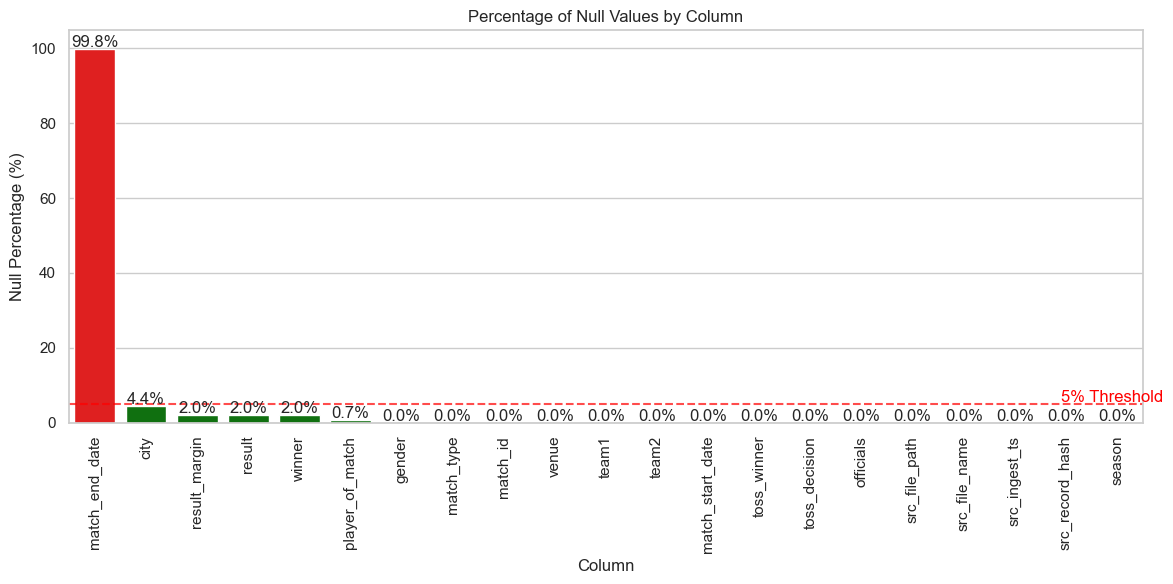


Season Distribution:


c:\Projects\CricketPipeline\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


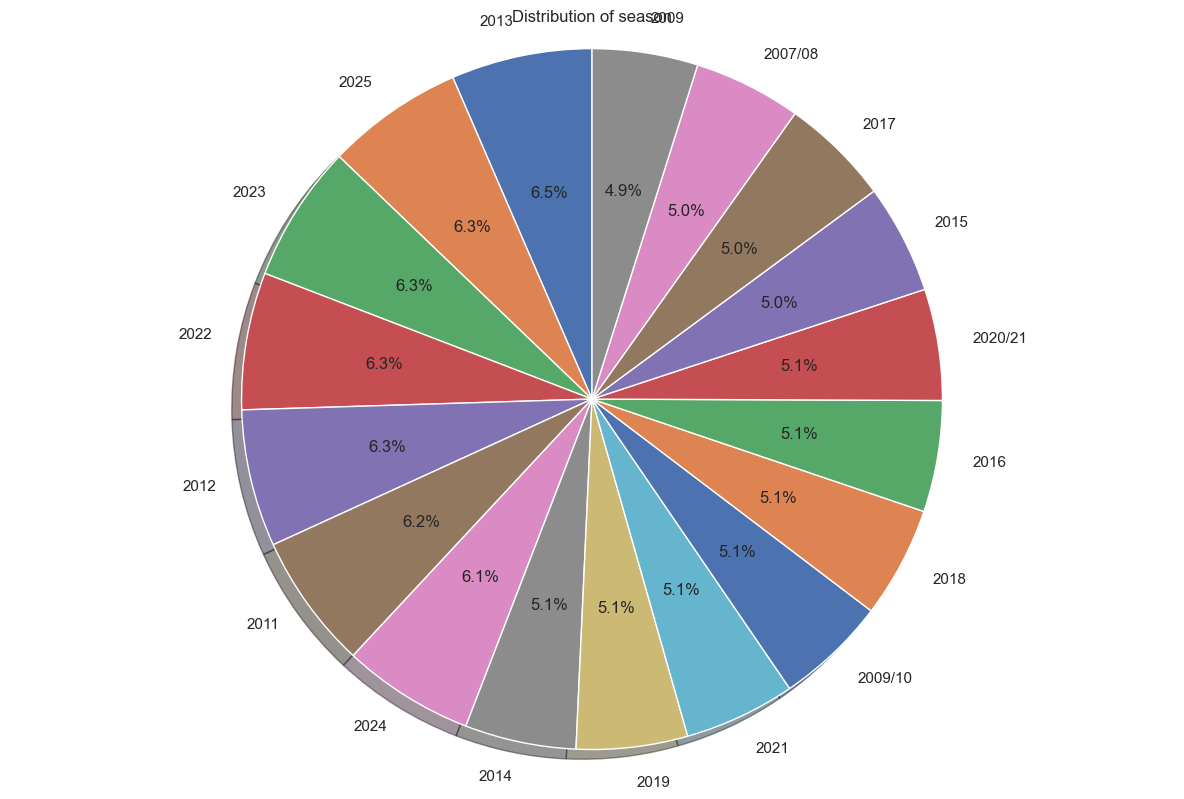


Team Distribution:


c:\Projects\CricketPipeline\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


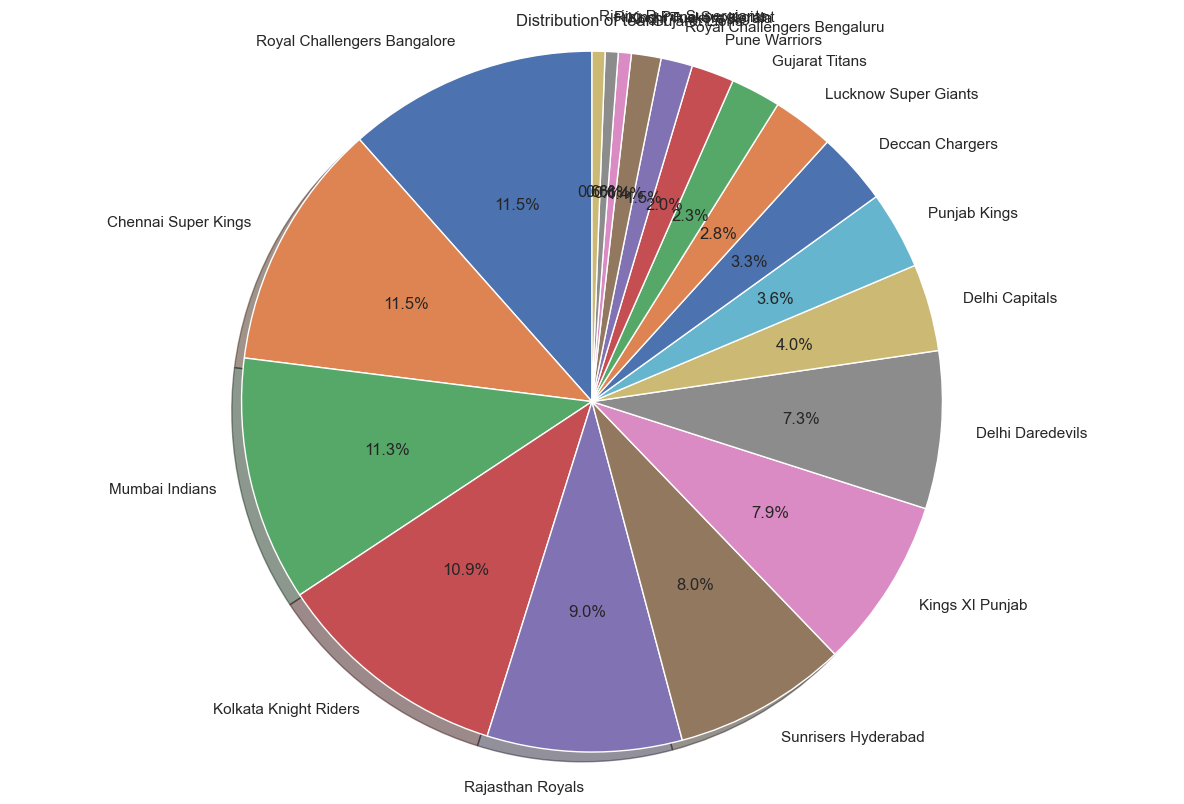

Loading table from C:\Projects\CricketPipeline\data\processed\bronze\deliveries
Loaded 278205 rows and 26 columns

Visualizing table: deliveries
Loaded 278205 rows and 26 columns

Visualizing table: deliveries

Null Value Visualization:

Null Value Visualization:


C:\Users\wasav\AppData\Local\Temp\ipykernel_30024\3006994894.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='column', y='null_percent', data=null_df,


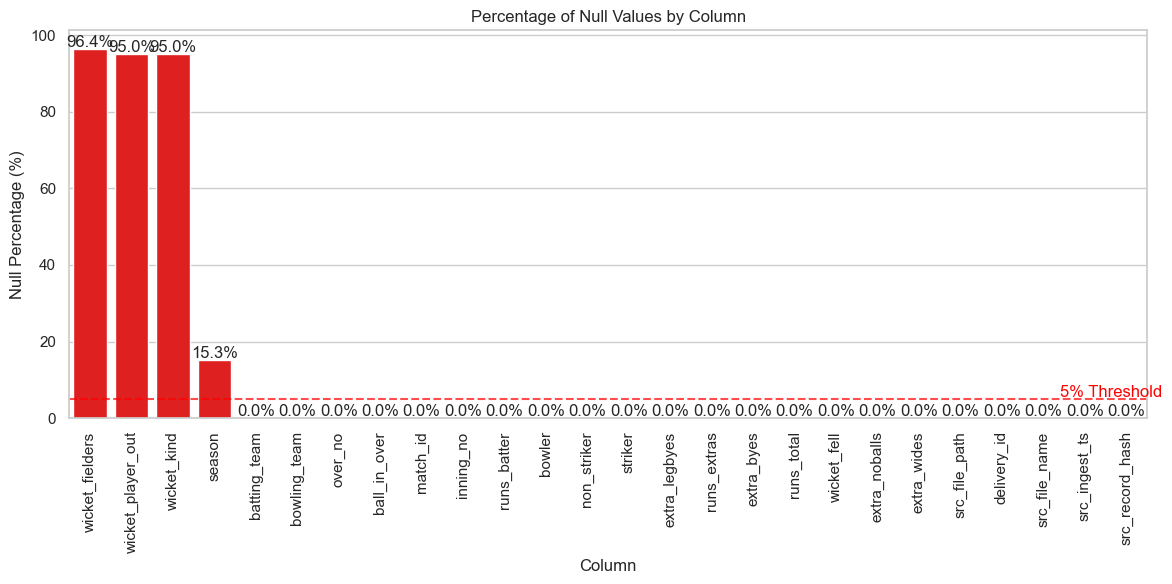


Batting Team Distribution:


c:\Projects\CricketPipeline\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


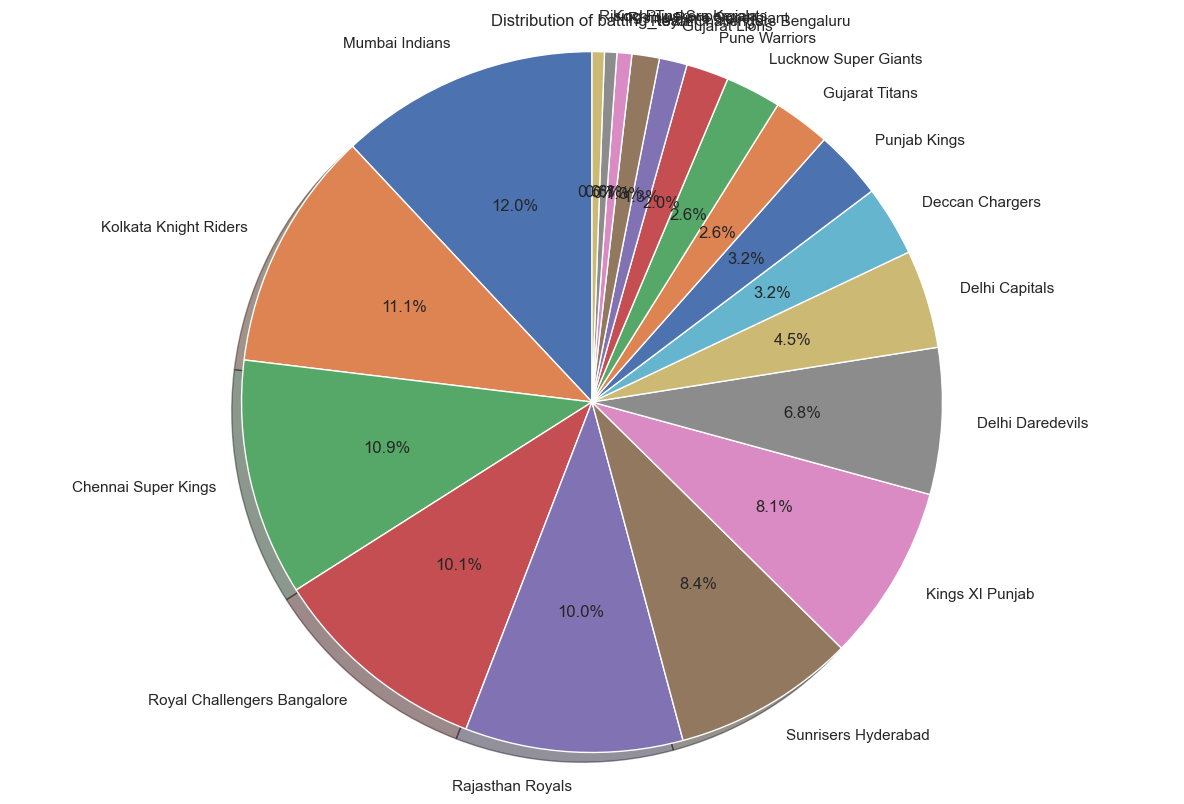

Loading table from C:\Projects\CricketPipeline\data\processed\bronze\innings
Error loading table: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.


In [18]:
# Function to visualize null percentages
def plot_null_percentages(null_df):
    plt.figure(figsize=(12, 6))
    
    # Sort by null percentage
    null_df = null_df.sort_values('null_percent', ascending=False)
    
    # Create the bar chart
    ax = sns.barplot(x='column', y='null_percent', data=null_df, 
                    palette=['green' if status == 'PASS' else 'red' for status in null_df['status']])
    
    # Add labels and title
    plt.xlabel('Column')
    plt.ylabel('Null Percentage (%)')
    plt.title('Percentage of Null Values by Column')
    plt.xticks(rotation=90)
    
    # Add threshold line
    plt.axhline(y=5, color='red', linestyle='--', alpha=0.7)
    plt.text(len(null_df)*0.9, 5.5, '5% Threshold', color='red')
    
    # Add value labels on the bars
    for i, v in enumerate(null_df['null_percent']):
        ax.text(i, v + 0.5, f'{v:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()

# Analyze and visualize data distributions for a specific column
def analyze_column_distribution(df, column_name):
    if column_name not in df.columns:
        print(f"Column {column_name} not in DataFrame")
        return
    
    # Get value counts
    value_counts = df.groupBy(column_name).count().orderBy("count", ascending=False)
    pd_counts = value_counts.toPandas()
    
    # Limit to top 20 values for visualization
    if len(pd_counts) > 20:
        other_count = pd_counts.iloc[20:]['count'].sum()
        pd_counts = pd_counts.iloc[:20]
        pd_counts.loc[len(pd_counts)] = ['Other', other_count]
    
    # Create the pie chart
    plt.figure(figsize=(12, 8))
    plt.pie(pd_counts['count'], labels=pd_counts[column_name], autopct='%1.1f%%', 
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title(f'Distribution of {column_name}')
    plt.tight_layout()
    plt.show()
    
    return pd_counts

# Run visualizations on loaded tables
for table_name in tables.keys():
    df = load_bronze_table(table_name)
    
    if df is not None:
        print(f"\n{'='*50}")
        print(f"Visualizing table: {table_name}")
        print(f"{'='*50}")
        
        # Visualize null percentages
        null_check = check_null_values(df)
        if not null_check.empty and "No data" not in null_check['column'].values:
            print("\nNull Value Visualization:")
            plot_null_percentages(null_check)
        
        # Visualize distributions for categorical columns
        if table_name == "matches" and "season" in df.columns:
            print("\nSeason Distribution:")
            analyze_column_distribution(df, "season")
        
        if table_name == "matches" and "team1" in df.columns:
            print("\nTeam Distribution:")
            analyze_column_distribution(df, "team1")
        
        if table_name == "deliveries" and "batting_team" in df.columns:
            print("\nBatting Team Distribution:")
            analyze_column_distribution(df, "batting_team")

## 6. Run Automated Tests

Let's create some automated tests for our quality check functions to ensure they work correctly with different data scenarios.

In [19]:
from pyspark.sql import Row

# Create test data
def create_test_data():
    # Test data with nulls
    test_null_data = [
        Row(id=1, name="Player1", age=25, team="Team A"),
        Row(id=2, name=None, age=30, team="Team B"),
        Row(id=3, name="Player3", age=None, team="Team A"),
        Row(id=4, name="Player4", age=28, team=None),
        Row(id=5, name=None, age=None, team=None),
    ]
    
    # Test data with duplicates
    test_dup_data = [
        Row(id=1, name="Player1", team="Team A"),
        Row(id=2, name="Player2", team="Team B"),
        Row(id=1, name="Player1", team="Team A"),  # Duplicate
        Row(id=3, name="Player3", team="Team C"),
        Row(id=2, name="Player2", team="Team B"),  # Duplicate
    ]
    
    null_df = spark.createDataFrame(test_null_data)
    dup_df = spark.createDataFrame(test_dup_data)
    
    return null_df, dup_df

# Test null check function
def test_null_check():
    null_df, _ = create_test_data()
    
    print("Testing null check function with test data:")
    null_df.show()
    
    result = check_null_values(null_df, threshold=0.2)
    print("\nNull check results:")
    display(result)
    
    # Verify results
    assert result[result['column'] == 'name']['null_count'].values[0] == 2, "Name should have 2 nulls"
    assert result[result['column'] == 'age']['null_count'].values[0] == 2, "Age should have 2 nulls"
    assert result[result['column'] == 'team']['null_count'].values[0] == 2, "Team should have 2 nulls"
    
    # Check status - name and age have 40% nulls which exceeds 20% threshold
    assert result[result['column'] == 'name']['status'].values[0] == "FAIL", "Name should fail threshold"
    assert result[result['column'] == 'age']['status'].values[0] == "FAIL", "Age should fail threshold"
    assert result[result['column'] == 'team']['status'].values[0] == "FAIL", "Team should fail threshold"
    
    print("✅ Null check test passed")

# Test duplicate check function
def test_duplicate_check():
    _, dup_df = create_test_data()
    
    print("Testing duplicate check function with test data:")
    dup_df.show()
    
    # Check duplicates using id and team
    result = check_duplicates(dup_df, ["id", "team"])
    print("\nDuplicate check results (by id, team):")
    for key, value in result.items():
        if key != "examples":
            print(f"{key}: {value}")
    
    # Verify results
    assert result["duplicate_records"] == 2, "Should find 2 duplicate records"
    assert result["status"] == "FAIL", "Status should be FAIL with duplicates"
    
    # Check duplicates using all columns (should be the same as before)
    result_all = check_duplicates(dup_df, ["id", "name", "team"])
    print("\nDuplicate check results (by all columns):")
    for key, value in result_all.items():
        if key != "examples":
            print(f"{key}: {value}")
    
    assert result_all["duplicate_records"] == 2, "Should find 2 duplicate records with all columns"
    
    print("✅ Duplicate check test passed")

# Run the tests
try:
    test_null_check()
    test_duplicate_check()
    print("\n🎉 All tests passed!")
except AssertionError as e:
    print(f"\n❌ Test failed: {str(e)}")

Testing null check function with test data:


Py4JJavaError: An error occurred while calling o418.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 352.0 failed 1 times, most recent failure: Lost task 0.0 in stage 352.0 (TID 1470) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more


## 7. Summary and Next Steps

We've set up quality checks for our bronze layer data and identified potential issues. Here's a summary of what we've accomplished:

1. Configured the environment to work with our project structure
2. Loaded the bronze configuration and initialized Spark
3. Defined functions for checking nulls, duplicates, and schema consistency
4. Performed quality checks on the bronze tables
5. Visualized data quality metrics
6. Created automated tests for our quality check functions

### Next Steps:

1. Implement more sophisticated quality checks
2. Set up automated monitoring for data quality
3. Create quality gates for the ETL pipeline
4. Document data quality requirements and thresholds
5. Extend checks to silver and gold layers